<a href="https://colab.research.google.com/github/patricksabry1/42028-Deep-Learning/blob/master/42028_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Pre-Processing

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import feature
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import accuracy_score
import cv2
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [24]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Load MNIST dataset from gdrive path

In [0]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [34]:
cd /content/gdrive/My Drive/42028-DL-CNN-2020/assignment-1/

/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-1


## Load the dataset and store into train/test split variables

In [45]:
X_train, y_train = load_mnist('/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-1/', kind='train')
X_test, y_test = load_mnist('/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-1/', kind='t10k')

# initialize the label names for MNIST digits
labelNames = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

X_train = X_train.reshape(-1,28,28)
X_test = X_test.reshape(-1,28,28)

# print the size of the result reshaped train and test data splits

print("Train dataset after reshaping:{}".format(np.shape(X_train)))
print("Test dataset after reshaping :{}".format(np.shape(X_test)))

Train dataset after reshaping:(60000, 28, 28)
Test dataset after reshaping :(10000, 28, 28)


## Visualise sample digits

3
0
3
5


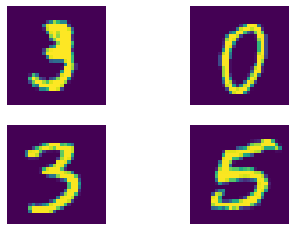

In [46]:
# view few images and print its corresponding label
img_index = 10
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.axis('off')
ax1.imshow(X_train[img_index])
print(labelNames[y_train[img_index]])

ax2 = fig.add_subplot(2,2,2)
ax2.axis('off')
img_index = 1000
ax2.imshow(X_train[img_index])
print(labelNames[y_train[img_index]])

ax2 = fig.add_subplot(2,2,3)
ax2.axis('off')
img_index = 10000
ax2.imshow(X_train[img_index])
print(labelNames[y_train[img_index]])

ax2 = fig.add_subplot(2,2,4)
ax2.axis('off')
img_index = 20000
ax2.imshow(X_train[img_index])
print(labelNames[y_train[img_index]])

## Extract Histogram-of-Oriented Gradient feature

The following utility function can be used to extract Histogram-of-gradients features for both train and test datasets.

In [0]:
def getHOG(X_train, y_train):
    # initialize the data matrix and labels
    print("Extracting features from training dataset...")
    hog_train = []
    hog_labels_train = []

    # loop over the training images
    for img_index in range(len(X_train)):
        # load the image, and extract HOG features
        image = (X_train[img_index])
        #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        H = feature.hog(image, orientations=9, pixels_per_cell=(10, 10),
                        cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")
        
        # update the data and labels
        hog_train.append(H)
        hog_labels_train.append(y_train[img_index])

    return hog_train, hog_labels_train

## Extract Local Binary Patterns feature
The following utility function can be used to extract Local Binary pattern features for both train and test datasets.

In [0]:
from skimage import feature
import numpy as np
import cv2

# Get LBP features for the dataset
class LocalBinaryPatterns:
	def __init__(self, numPoints, radius):
		# store the number of points and radius
		self.numPoints = numPoints
		self.radius = radius
 
	def LBPfeatures(self, image, eps=1e-7):
		# compute the Local Binary Pattern representation
		# of the image, and then use the LBP representation
		# to build the histogram of patterns
		lbp = feature.local_binary_pattern(image, self.numPoints,
			self.radius, method="uniform")
        # Form the histogram
		(hist, _) = np.histogram(lbp.ravel(),
			bins=np.arange(0, self.numPoints + 3),
			range=(0, self.numPoints + 2))
 
		# normalize the histogram
		hist = hist.astype("float")
		hist /= (hist.sum() + eps)
 
		# return the histogram of Local Binary Patterns
		return hist

def getLBPFeatures(X_train, y_train):
    # Create an object of LocalBinaryPatterns class and initial the parameters.
    desc = LocalBinaryPatterns(24, 8)
    lbp_train = []
    lbp_labels_train = []

    # loop over the training images
    for img_index in range(len(X_train)):
        # load the image, convert it to grayscale, and extract LBP features
        image = (X_train[img_index])
        hist = desc.LBPfeatures(image)
    
        # extract the label from the image path, then update the
        # label and data lists
        lbp_labels_train.append(y_train[img_index])
        lbp_train.append(hist)
            
    return lbp_train, lbp_labels_train

# SVM

## SVM fitted on LBP features

In [55]:
from sklearn.svm import LinearSVC

lbp_train, lbp_labels_train, = getLBPFeatures(X_train, y_train)
print(np.shape(lbp_train))
print(np.shape(lbp_labels_train))

model = LinearSVC(C=100.0, random_state=42)
model.fit(lbp_train, lbp_labels_train)

# Check the training accuray
print("Train set Accuracy: {:.2f}".format(model.score(lbp_train, lbp_labels_train)))


(60000, 26)
(60000,)
Train set Accuracy: 0.46


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## SVM fitted on HOG features

In [62]:
hog_train, hog_labels_train = getHOG(X_train, y_train)
model = svm.SVC(kernel='rbf',C=100.0, random_state=42) # rbf Kernel
model.fit(hog_train, hog_labels_train)

print("Train set Accuracy: {:.2f}".format(model.score(hog_train, hog_labels_train)))

Extracting features from training dataset...
Train set Accuracy: 0.99


# CNN

## Define & compile neural network + fit on dataset

In [0]:
# Define CNN model with
    # Declare input shape for first layer of CNN
    input_shape = (28, 28, 1)
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=input_shape),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
model.summary()

model.fit(x_train, y_train, epochs=20)


ERROR! Session/line number was not unique in database. History logging moved to new session 59
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2931 - accuracy: 0.9151
Epoch 2/20
1875/1875 [===========================

## Evaluate trained model on validation data

In [0]:
model.evaluate(x_test,  y_test, verbose=2)


313/313 - 1s - loss: 0.0858 - accuracy: 0.9800


[0.08582599461078644, 0.9800000190734863]

# KNN